# Advanced Lane Detection Using Computer Vision

Identifying lanes on the road is a common task performed by all human drivers to ensure their vehicles are within lane constraints when driving, so as to make sure traffic is smooth and minimize chances of collisions with other cars due to lane misalignment.

Similarly, it is a critical task for an autonomous vehicle to perform. It turns out that recognising lane markings on roads is possible using well known computer vision techniques. We will cover how to use various techniques to identify and draw the inside road lanes, lane curvature, and even estimate the vehicle position relative to the lane.

This is project 4 of Term 1 of the Udacity Self Driving Car Engineer Nanodegree.

# Calibration And Undistortion

## Camera Calibration

The first step we will take is to find the calibration matrix, along with distortion coefficient for the camera that was used to take pictures of the road. This is necessary because the convex shape of camera lenses curves light rays as the enter the pinhole, therefore causing distortions to the real image. Therefore lines that are straight in the real world may not be anymore on our photos. 

To compute the camera the transformation matrix and distortion coefficients, we use a multiple pictures of a _chessboard_ on a flat surface taken **by the same camera**. OpenCV has a convenient method called [findChessboardCorners](http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#cv2.findChessboardCorners) that will identify the points where black and white squares intersect and reverse engineer the distorsion matrix this way. 

**ADD IMAGE OF PINHOLE MODEL**

**ADD IMAGE OF CHESSBOARD CORNERS FINDING**

In [655]:
# Main imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [656]:
calibration_dir = "camera_cal"
test_imgs_dir = "test_images"
output_imgs_dir = "output_images"

In [657]:
def load_image(path, to_rgb=True):
    img = cv2.imread(path)
    return img if not to_rgb else cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [658]:
def show_image_list(img_list, img_labels, title, cols=2, fig_size=(15, 15), show_ticks=True):
    """
    Utility function to show us a list of traffic sign images
    """
    #img_count = len(img_list)
    #rows = img_count // cols
    rows = len(img_list)
    cmap = None
    
    fig, axes = plt.subplots(rows, cols, figsize=fig_size)

    for i in range(0, rows):
        for j in range(0, cols):
            ax = axes[i, j] if rows > 1 else axes[j]
            #k = i * cols + j
            img_name = img_labels[i][j]   
            img = img_list[i][j]
            if len(img.shape) < 3 or img.shape[-1] < 3:
                cmap = "gray"
                img = np.reshape(img, (img.shape[0], img.shape[1]))

            if not show_ticks:            
                ax.axis("off")

            ax.imshow(img, cmap=cmap)
            ax.set_title(img_name)
                
    fig.suptitle(title, fontsize=12, fontweight='bold', y = 1)
    fig.tight_layout()
    plt.show()
    
    return

### Finding Chessboard Corners

We must determine the number of inner corners horizontally and vertically for our sample chessboard pictures.

In [659]:
# Let's get all our calibration image paths
cal_imgs_paths = glob.glob(calibration_dir + "/*.jpg")

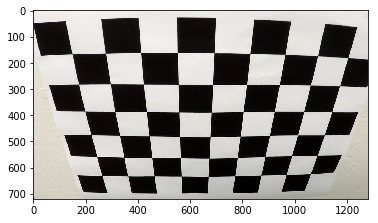

In [660]:
# Let's the first chessboard image to see what it looks like
cal_img_path = cal_imgs[11]
cal_img = load_image(cal_img_path)
plt.imshow(cal_img)

Our chessboard has *9* inner corners in the x direction, and *6* in the y direction. We will use these as parameters to *findChessboardCorners()*.

In [661]:
cx = 9
cy = 6

We submit grayscale images to _findChessboardCorners_ so we must therefore define a utility method for this purpose.

In [662]:
def to_grayscale(img):
    """
    Returns the grayscaled version of the supplied image (in RGB format)
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [663]:
def findChessboardCorners(img, nx, ny):
    """
    Finds the chessboard corners of the supplied image (must be grayscale)
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    return cv2.findChessboardCorners(img, (nx, ny), None)        

In [664]:
def showChessboardCorners(img, nx, ny, ret, corners):
    """
    Draws the chessboard corners of a given image
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    ret and corners should represent the results from cv2.findChessboardCorners()
    """
    c_img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)

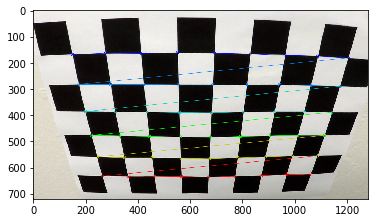

In [665]:
ret, corners = findChessboardCorners(to_grayscale(cal_img), cx, cy)
showChessboardCorners(cal_img, cx, cy, ret, corners)

We can see that corners are very well identified. Next we identify image and object points to calibrate the camera.

### Image Undistortion

#### Identifying Image And Object Points

We find the mappings for coordinates of the images in 2D space (i.e. *image points*) to those of the undistorted image in the real-world (i.e. *object points*)

In [666]:
def findImgObjPoints(imgs_paths, nx, ny):
    """
    Returns the objects and image points computed for a set of chessboard pictures taken from the same camera
    nx and ny parameters respectively indicate the number of inner corners in the x and y directions
    """
    objpts = []
    imgpts = []
    
    # Pre-compute what our object points in the real world should be (the z dimension is 0 as we assume a flat surface)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    
    for img_path in imgs_paths:
        img = load_image(img_path)
        gray = to_grayscale(img)
        ret, corners = findChessboardCorners(gray, nx, ny)
        
        if ret:
            # Found the corners of an image
            imgpts.append(corners)
            # Add the same object point since they don't change in the real world
            objpts.append(objp)
    
    return objpts, imgpts

In [667]:
opts, ipts = findImgObjPoints(cal_imgs_paths, cx, cy)

In [668]:
len(ipts)

17

#### Finding Calibration Matrix

In [669]:
def undistort_image(img, objpts, imgpts):
    """
    Returns an undistorted image
    The desired object and image points must also be supplied to this function
    """
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, to_grayscale(img).shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [670]:
test_imgs_paths = glob.glob(test_imgs_dir + "/*.jpg")

In [671]:
test_img_path = test_imgs_paths[5]
test_img = load_image(test_img_path)

In [673]:
undistorted_test_img = undistort_image(test_img, opts, ipts)

In [84]:
test_img_names = np.asarray(list(map(lambda img_path: img_path.split("/")[-1].split(".")[0], test_imgs_paths)))
undist_test_img_names = np.asarray(list(map(lambda img_name: "{0}{1}".format("undistorted_", img_name), test_img_names)))

In [88]:
test_imgs = np.asarray(list(map(lambda img_path: load_image(img_path), test_imgs_paths)))
undist_test_imgs = np.asarray(list(map(lambda img: undistort_image(img, opts, ipts), test_imgs)))

In [85]:
undist_test_img_names

array(['undistorted_straight_lines1', 'undistorted_straight_lines2',
       'undistorted_test1', 'undistorted_test2', 'undistorted_test3',
       'undistorted_test4', 'undistorted_test5', 'undistorted_test6'],
      dtype='<U27')

In [107]:
test_img_and_undist = np.asarray(list(zip(test_imgs, undist_test_imgs)))
test_img_and_undist_names = np.asarray(list(zip(test_img_names, undist_test_img_names)))

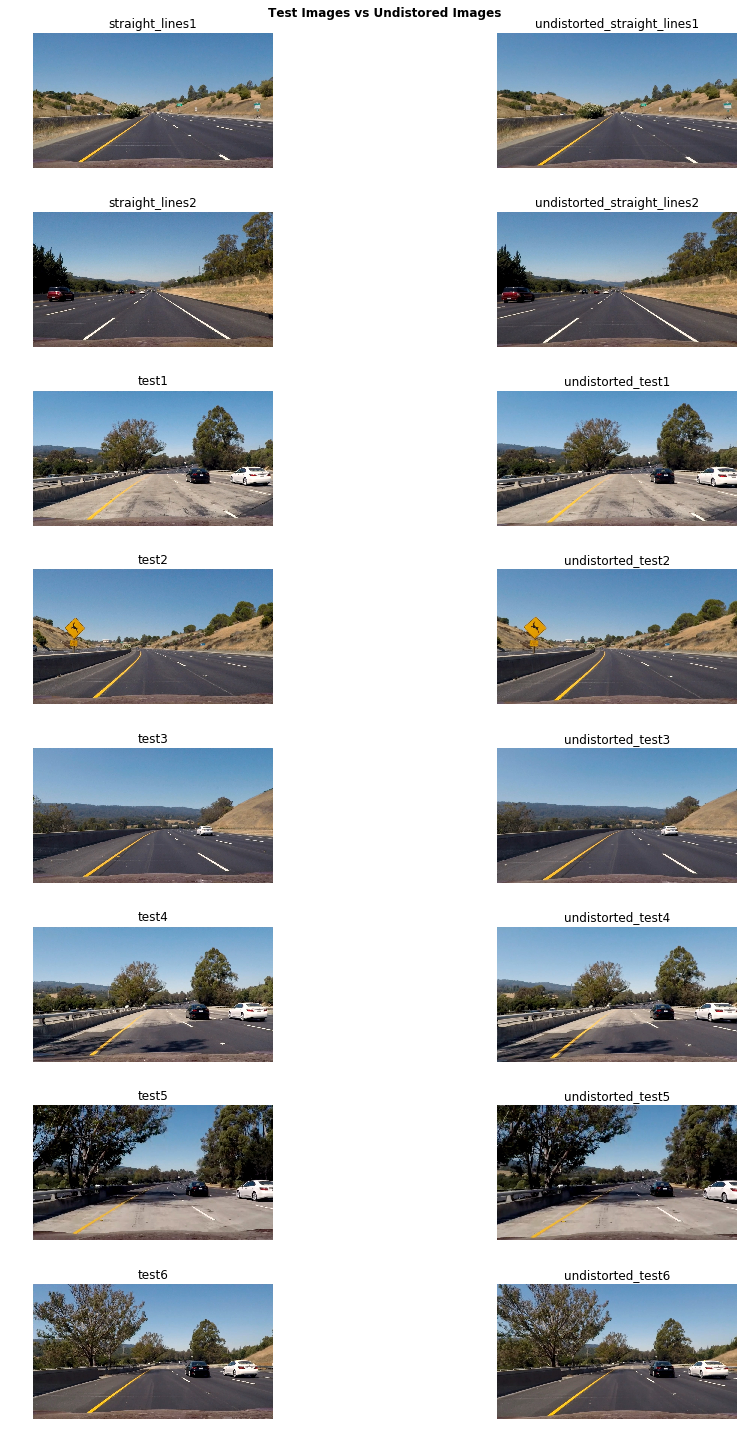

In [567]:
show_image_list(test_img_and_undist, test_img_and_undist_names, "Test Images vs Undistored Images", fig_size=(15, 20), cols=2, show_ticks=False)


The sample above shows original next to undistored images.

## Thresholding

We apply edge and color thresholding in this section to better detect the lines, and make it easier to find the polynomial that best describes our left and right lanes later.

### Gradient Thresholding Via Sobel

We use the [Sobel](https://en.wikipedia.org/wiki/Sobel_operator) operator to identify _gradients_, that is change in _color intensity_ in the image. Higher values would denote strong gradients, and therefore sharp changes in color.

#### Sobel In X or Y Directions

In [118]:
def abs_sobel(gray_img, x_dir=True, kernel_size=3, thres=(0, 255)):
    """
    Applies the sobel operator to a grayscale image in either horizontal or vertical direction
    The function also computes the asbolute value of the resulting matrix and applies a binary threshold
    """
    sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size) if x_dir else cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size) 
    sobel_abs = np.absolute(sobel)
    sobel_scaled = np.uint8(255 * sobel / np.max(sobel_abs))
    
    gradient_mask = np.zeros_like(sobel_scaled)
    gradient_mask[(thres[0] <= sobel_scaled) & (sobel_scaled <= thres[1])] = 1
    return gradient_mask

In [295]:
undist_test_img_gray = to_grayscale(undistorted_test_img)

In [327]:
sobx_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, thres=(20, 120)), abs_sobel(undist_test_img_gray, thres=(50, 150)), abs_sobel(undist_test_img_gray, thres=(80, 200))]])
sobx_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobx_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobx_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobx_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobx_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobx_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobx_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [328]:
sobx_thres = np.concatenate((sobx_3x3_thres, sobx_7x7_thres, sobx_11x11_thres, sobx_15x15_thres))
sobx_thres_lbs = np.concatenate((sobx_3x3_thres_lbs, sobx_7x7_thres_lbs, sobx_11x11_thres_lbs, sobx_15x15_thres_lbs))

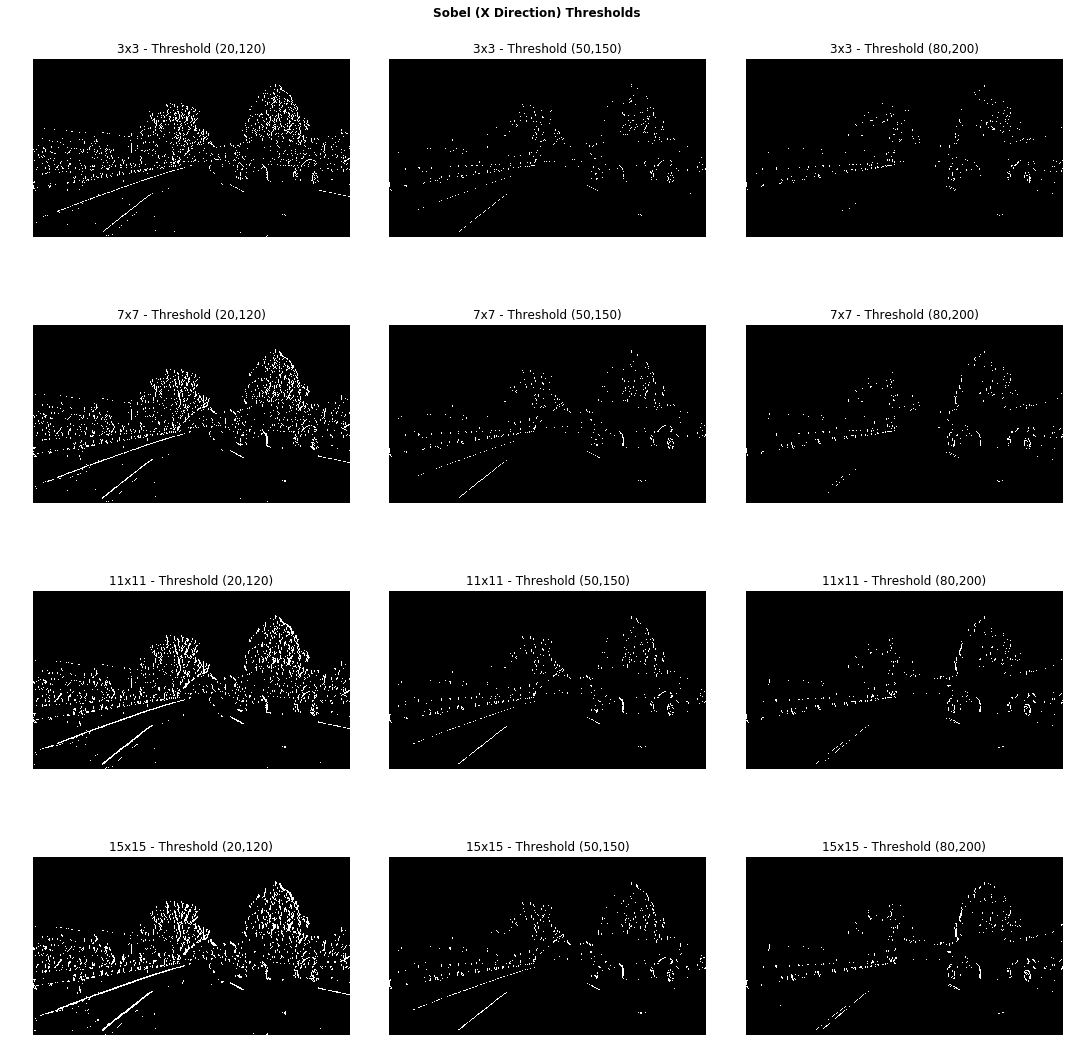

In [462]:
show_image_list(sobx_thres, sobx_thres_lbs, "Sobel (X Direction) Thresholds", cols=3, show_ticks=False)

We obtain the best results for Sobel in the X direction with thresholds values between in the interval _[20,120]_, using a kernel size of 15 (lines are very crisp).

In [438]:
# Saving our best sobel results
sobx_best = abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120))

In [309]:
sobx = abs_sobel(to_grayscale(undistorted_test_img), thres=(50, 200))

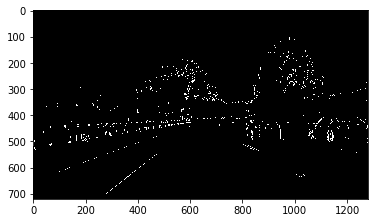

In [310]:
plt.imshow(sobx, cmap='gray')

In [330]:
soby_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(80, 200))]])
soby_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(80, 200))]])
soby_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(80, 200))]])
soby_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(80, 200))]])

soby_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
soby_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
soby_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
soby_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [331]:
soby_thres = np.concatenate((soby_3x3_thres, soby_7x7_thres, soby_11x11_thres, soby_15x15_thres))
soby_thres_lbs = np.concatenate((soby_3x3_thres_lbs, soby_7x7_thres_lbs, soby_11x11_thres_lbs, soby_15x15_thres_lbs))

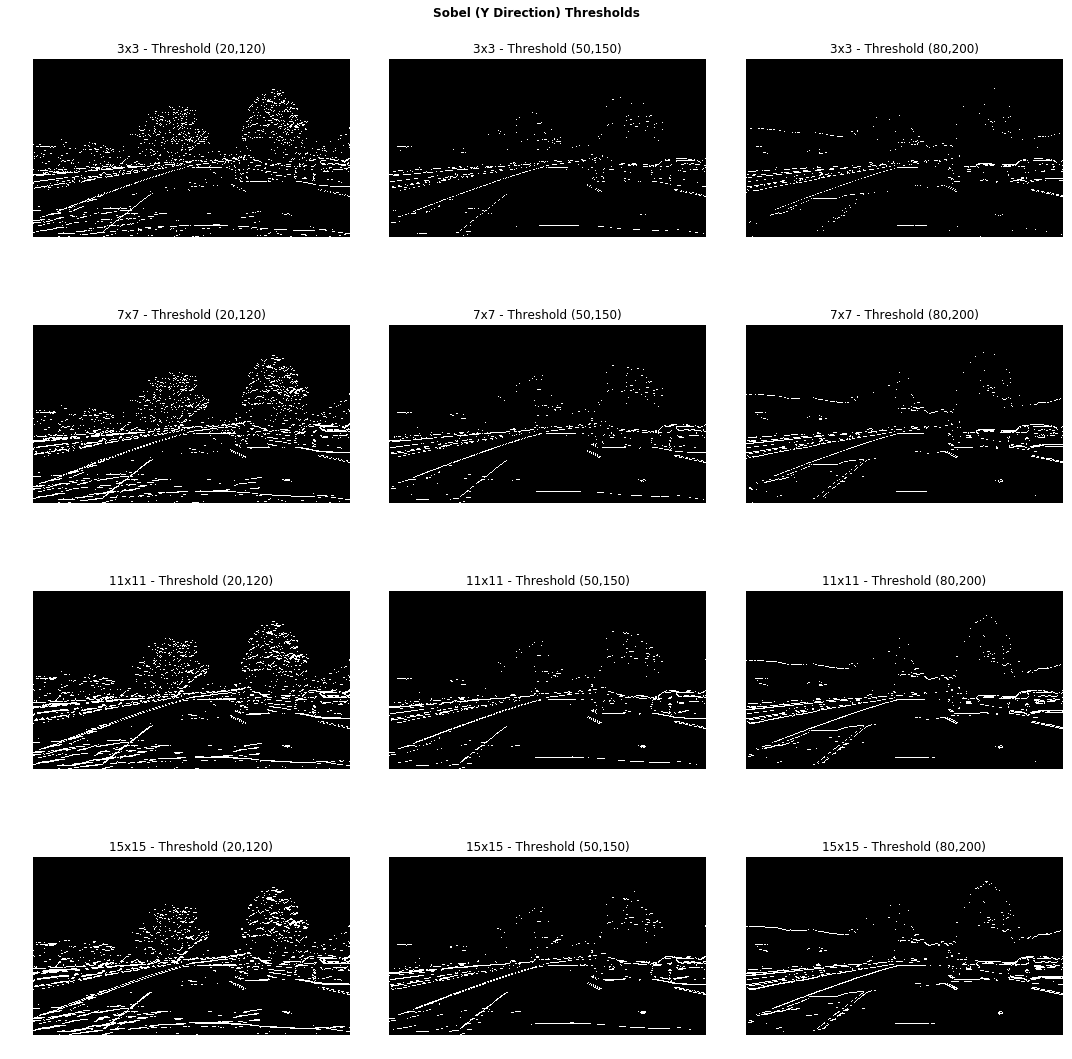

In [332]:
show_image_list(soby_thres, soby_thres_lbs, "Sobel (Y Direction) Thresholds", cols=3, show_ticks=False)

In the Y direction, our best Sobel configuration is with thresholds in the interval _[50,150]_ and kernel size 15.

In [439]:
# Saving our best sobel y result
soby_best = abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(50, 150))

In [ ]:
soby = abs_sobel(to_grayscale(undistorted_test_img), x_dir=False, thres=(50, 150))

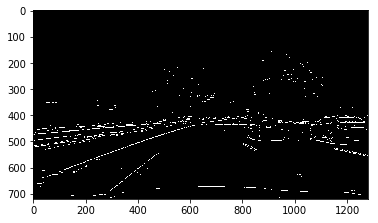

In [208]:
plt.imshow(soby, cmap='gray')

#### Sobel Magnitude in X and Y Directions

In [130]:
def mag_sobel(gray_img, kernel_size=3, thres=(0, 255)):
    """
    Computes sobel matrix in both x and y directions, merges them by computing the magnitude in both directions
    and applies a threshold value to only set pixels within the specified range
    """
    sx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sy = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    sxy = np.sqrt(np.square(sx) + np.square(sy))
    scaled_sxy = np.uint8(255 * sxy / np.max(sxy))
    
    sxy_binary = np.zeros_like(scaled_sxy)
    sxy_binary[(scaled_sxy >= thres[0]) & (scaled_sxy <= thres[1])] = 1
    
    return sxy_binary

In [440]:
sobxy_3x3_thres = np.asarray([[mag_sobel(undistorted_test_img_gray, kernel_size=3, thres=(20, 80)), mag_sobel(undistorted_test_img_gray, kernel_size=3, thres=(50, 150)), mag_sobel(undistorted_test_img_gray, kernel_size=3, thres=(80, 200))]])
sobxy_7x7_thres = np.asarray([[mag_sobel(undistorted_test_img_gray, kernel_size=7, thres=(20, 80)), mag_sobel(undistorted_test_img_gray, kernel_size=7, thres=(50, 150)), mag_sobel(undistorted_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobxy_11x11_thres = np.asarray([[mag_sobel(undistorted_test_img_gray, kernel_size=11, thres=(20, 80)), mag_sobel(undistorted_test_img_gray, kernel_size=11, thres=(50, 150)), mag_sobel(undistorted_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobxy_15x15_thres = np.asarray([[mag_sobel(undistorted_test_img_gray, kernel_size=15, thres=(20, 80)), mag_sobel(undistorted_test_img_gray, kernel_size=15, thres=(50, 150)), mag_sobel(undistorted_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobxy_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,80)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobxy_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,80)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobxy_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,80)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobxy_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,80)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [441]:
sobxy_thres = np.concatenate((sobxy_3x3_thres, sobxy_7x7_thres, sobxy_11x11_thres, sobxy_15x15_thres))
sobxy_thres_lbs = np.concatenate((sobxy_3x3_thres_lbs, sobxy_7x7_thres_lbs, sobxy_11x11_thres_lbs, sobxy_15x15_thres_lbs))


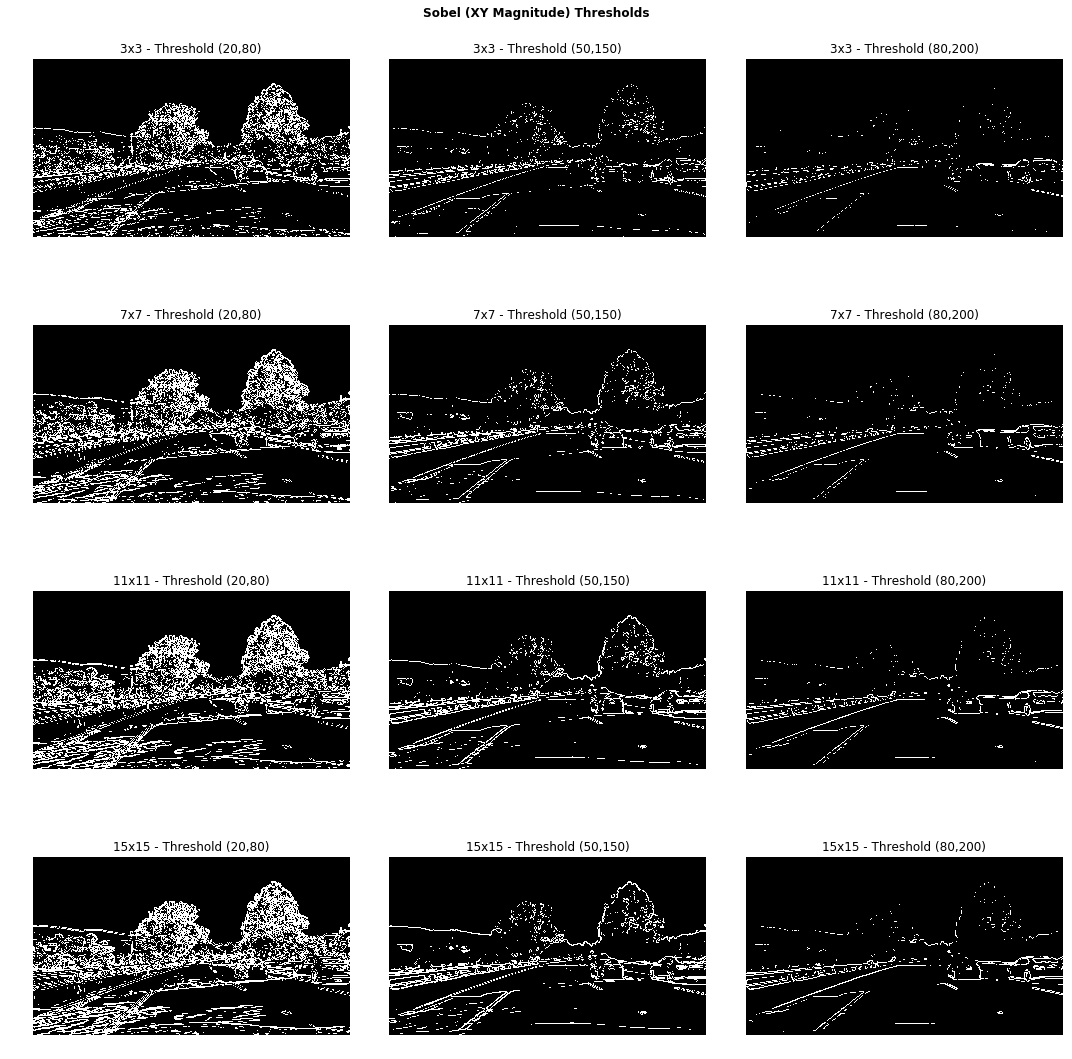

In [474]:
show_image_list(sobxy_thres, sobxy_thres_lbs, "Sobel (XY Magnitude) Thresholds", cols=3, show_ticks=False)

Since we plan to combine this Sobel result, we believe we get enough information for interval _[50, 150]_ and kernel size 15.

In [443]:
# Saving our best Sobel XY magnitude results
sobxy_best = mag_sobel(undistorted_test_img_gray, kernel_size=15, thres=(50, 150))

In [371]:
sob_xy = mag_sobel(undist_test_img_gray, thres=(80, 255))

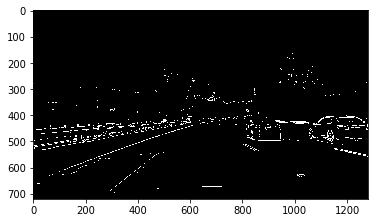

In [372]:
plt.imshow(sob_xy, cmap='gray')

#### Sobel With Gradient Direction

This Sobel operation is extremely noisy and it becomes quite hard to decipher the result if we do not combine it with our previous sobel operations and produce a binary output.

In [417]:
def dir_sobel(gray_img, kernel_size=3, thres=(0, np.pi/2)):
    """
    Computes sobel matrix in both x and y directions, gets their absolute values to find the direction of the gradient
    and applies a threshold value to only set pixels within the specified range
    """
    sx_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size))
    sy_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size))
    
    dir_sxy = np.arctan2(sx_abs, sy_abs)

    binary_output = np.zeros_like(dir_sxy)
    binary_output[(dir_sxy >= thres[0]) & (dir_sxy <= thres[1])] = 1
    
    return binary_output

In [447]:
def combined_sobels(sx_binary, sy_binary, sxy_magnitude_binary, gray_img, kernel_size=3, angle_thres=(0, np.pi/2)):
    sxy_direction_binary = dir_sobel(gray_img, kernel_size=kernel_size, thres=angle_thres)
    
    combined = np.zeros_like(sxy_direction_binary)
    # Sobel X returned the best output so we keep all of its results. We perform a binary and on all the other sobels
    #combined[(sx_binary == 1) | ((sy_binary == 1) & (sxy_magnitude_binary == 1) & (sxy_direction_binary == 1))] = 1
    combined[((sx_binary == 1)) | ((sxy_magnitude_binary == 1) & (sxy_direction_binary == 1))] = 1
    
    return combined

In [448]:
cb = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray)

In [449]:
sobxy_combined_dir_3x3_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_7x7_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_11x11_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_15x15_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/3, np.pi/2))
                                           ]])


sobxy_combined_dir_3x3_thres_lbs = np.asarray([["3x3 - Combined (0, pi/4)", "3x3 - Combined (pi/4, pi/2)", "3x3 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_7x7_thres_lbs = np.asarray([["7x7 - Combined (0, pi/4)", "7x7 - Combined (pi/4, pi/2)", "7x7 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_11x11_thres_lbs = np.asarray([["11x11 - Combined (0, pi/4)", "11x11 - Combined (pi/4, pi/2)", "11x11 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_15x15_thres_lbs = np.asarray([["15x15 - Combined (0, pi/4)", "15x15 - Combined (pi/4, pi/2)", "15x15 - Combined (pi/3, pi/2)"]])

In [450]:
sobxy_combined_dir_thres = np.concatenate((sobxy_combined_dir_3x3_thres, sobxy_combined_dir_7x7_thres, sobxy_combined_dir_11x11_thres, sobxy_combined_dir_15x15_thres))
sobxy_combined_dir_thres_lbs = np.concatenate((sobxy_combined_dir_3x3_thres_lbs, sobxy_combined_dir_7x7_thres_lbs, sobxy_combined_dir_11x11_thres_lbs, sobxy_combined_dir_15x15_thres_lbs))



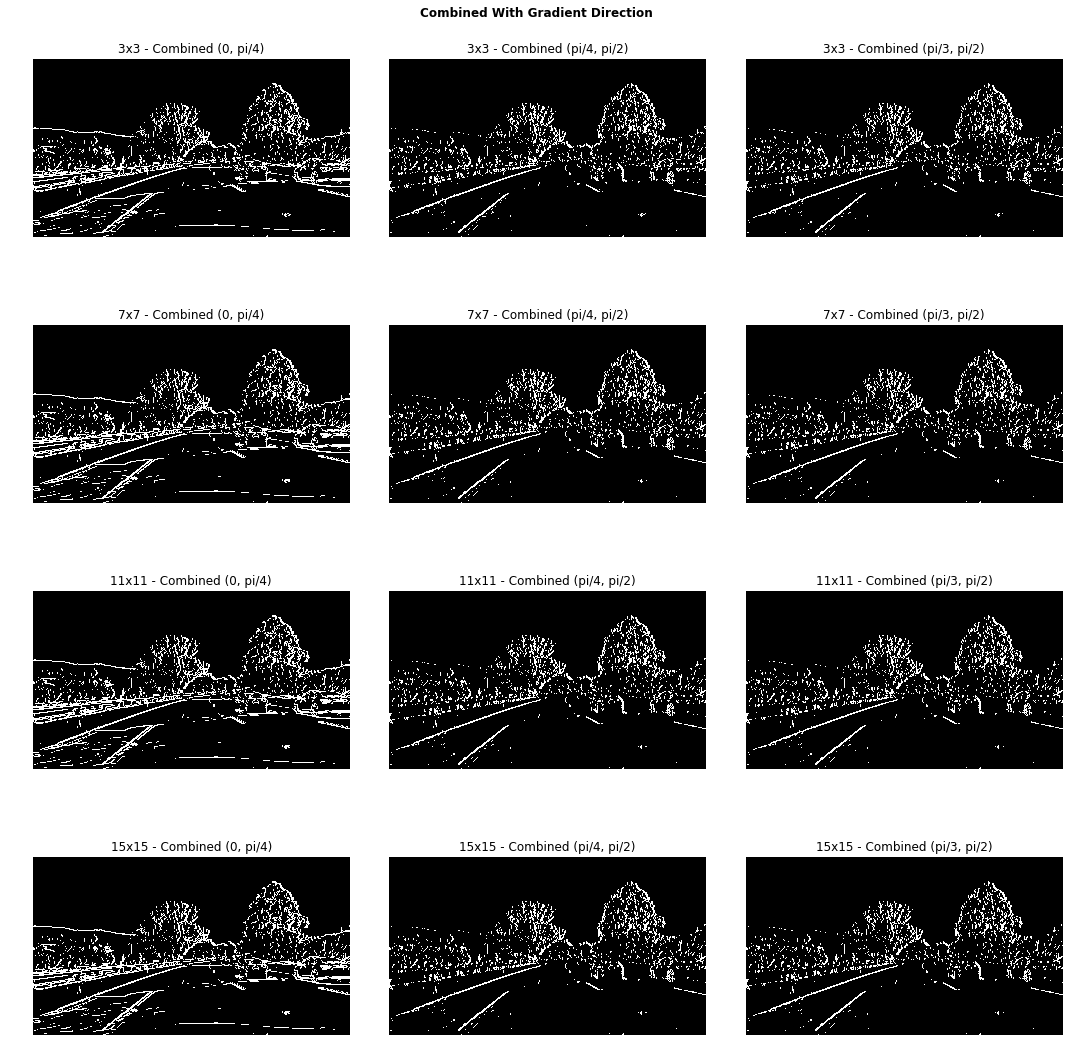

In [451]:
show_image_list(sobxy_combined_dir_thres, sobxy_combined_dir_thres_lbs, "Combined With Gradient Direction", cols=3, show_ticks=False)

Interestingly, the kernel size does not seem to affect the direction sobel operation so much. It's also hard to determine which one is the "best" result out of all our visualisations. Since we want to retain only information about lane lines, we are inclined to elect interval _[pi/4, pi/2]_ as our best configuration as it gives us the most room for manoeuvre. Kernel size of 15x15 produces the least noise.

In [453]:
sobel_combined_best = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))                                                                            

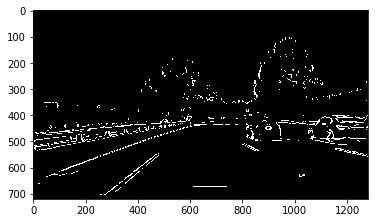

In [387]:
plt.imshow(cb, cmap='gray')

In [436]:
sob_xy_dir = dir_sobel(undist_test_img_gray, thres=(0.5, 1.5))

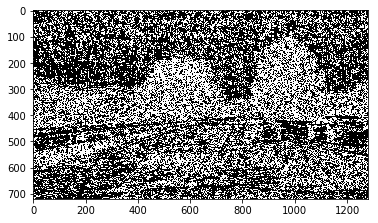

In [437]:
plt.imshow(sob_xy_dir, cmap='gray')

In [429]:
combined = np.zeros_like(sob_xy_dir)
combined[(sob_xy == 1) & (sob_xy_dir == 1)] = 1

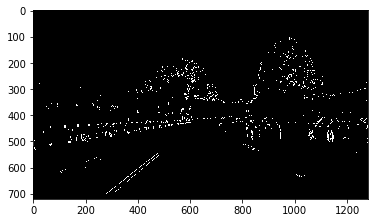

In [202]:
plt.imshow(combined, cmap='gray')

The resulting image from combined variant of sobel operations shows promise. However, we can see that some lanes are not fully identified, due to shadows obscuring the image. We turn to color space manipulation in order to better isolate the yellow and white lines.

### Color Thresholding

We experiment with different color spaces and try out some thresolding values to identify the best parameters and most suitable color space and channel to pick.

In [209]:
def to_hls(img):
    """
    Returns the same image in HLS format
    The input image must be in RGB format
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

In [232]:
def threshold_img(img, channel, thres=(0, 255)):
    """
    Applies a threshold mask to the input image
    """
    img_ch = img[:,:,channel]
    if thres is None:  
        return img_ch
    
    mask_ch = np.zeros_like(img_ch)
    mask_ch[ (thres[0] <= img_ch) & (thres[1] >= img_ch) ] = 1
    return mask_ch

In [282]:
rgb_comp = np.asarray([[threshold_img(undistorted_test_img, 0, thres=None), threshold_img(undistorted_test_img, 1, thres=None), threshold_img(undistorted_test_img, 2, thres=None)]])
rgb_lbs = np.asarray([["Red Channel", "Green Channel", "Blue Channel"]])

In [283]:
hls_test_img = to_hls(undistorted_test_img)
hls_comp = np.asarray([[threshold_img(hls_test_img, 0, thres=None), threshold_img(hls_test_img, 1, thres=None), threshold_img(hls_test_img, 2, thres=None)]])
hls_lbs = np.asarray([["Hue Channel", "Lightness Channel", "Saturation Channel"]])

In [284]:
color_spaces_comps = np.concatenate((rgb_comp, hls_comp))
color_spaces_lbs = np.concatenate((rgb_lbs, hls_lbs))

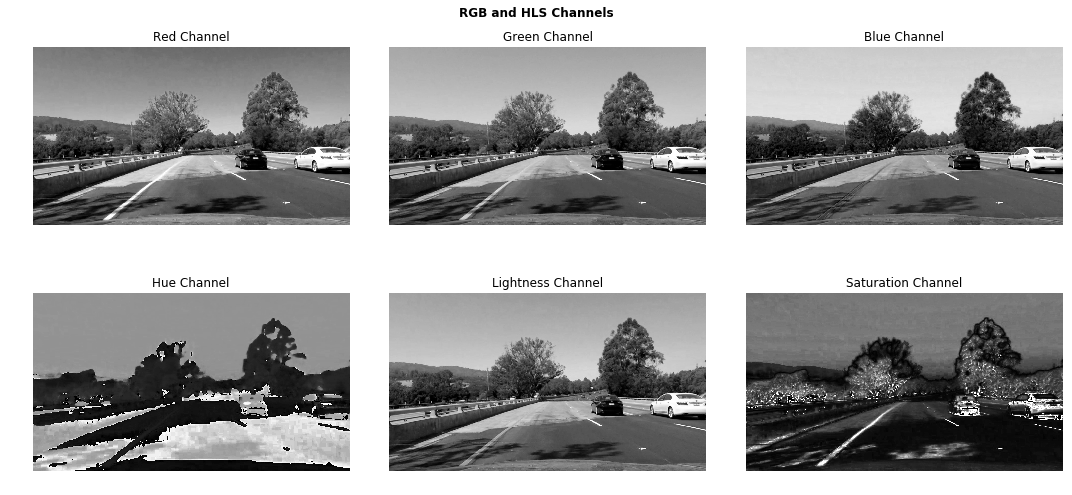

In [293]:
show_image_list(color_spaces_comps, color_spaces_lbs, "RGB and HLS Channels", cols=3, fig_size=(15, 7), show_ticks=False)

On the RGB components, we see that the blue channel gives the least clarity on the lines, while the red channel seems to give best results.

For HSL, the hue channel produces an extremely noisy output, while the saturation channel seems to give the best results. **The saturation channel in fact seems to produce the best contrast** so we will therefore focus on trying different thresholds for this channel.

In [289]:
hls_s_thres_1 = np.asarray([[threshold_img(hls_test_img, 2, thres=(0, 85)), threshold_img(hls_test_img, 2, thres=(85, 170)), threshold_img(hls_test_img, 2, thres=(170, 255))]])
hls_s_lbs_1 = np.asarray([["S Thresold (0,85)", "S Thresold (85,170)", "S Thresold (170,255)"]])

hls_s_thres_2 = np.asarray([[threshold_img(hls_test_img, 2, thres=(50, 100)), threshold_img(hls_test_img, 2, thres=(100, 150)), threshold_img(hls_test_img, 2, thres=(150, 255))]])
hls_s_lbs_2 = np.asarray([["S Thresold (50,100)", "S Thresold (100,150)", "S Thresold (150,255)"]])


In [290]:
hls_s_thres = np.concatenate((hls_s_thres_1, hls_s_thres_2))
hls_s_lbs = np.concatenate((hls_s_lbs_1, hls_s_lbs_2))

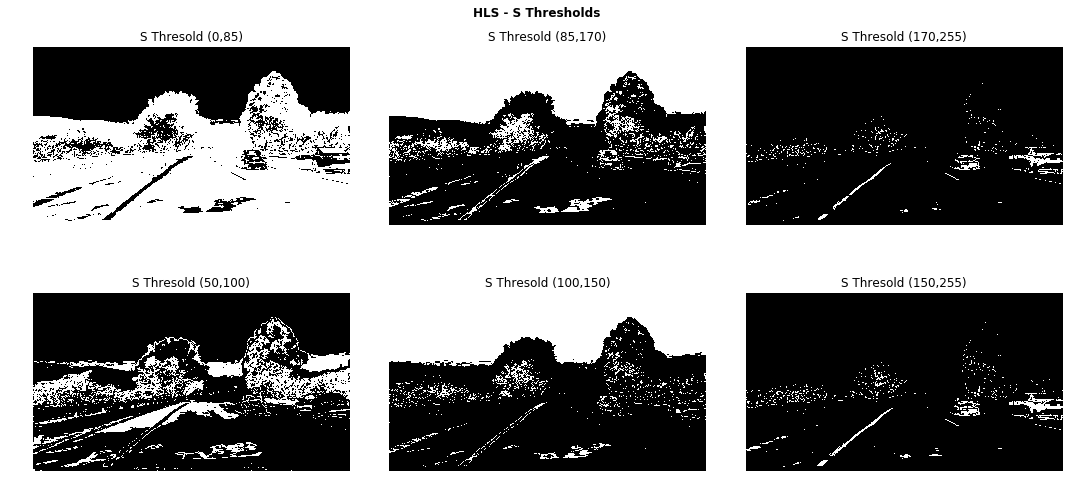

In [292]:
show_image_list(hls_s_thres, hls_s_lbs, "HLS - S Thresholds", cols=3, fig_size=(15, 7), show_ticks=False)


We seem to obtain the best results with thresholding on the saturation channel with values in the interval _[50,255]_. We will use this interval going forward.

In [454]:
hls_s_binary_best = threshold_img(hls_test_img, 2, thres=(150, 255))

### Combining Color And Gradient (Sobel) Thresholds

In [484]:
color_binary = np.dstack((np.zeros_like(hls_s_binary_best), sobel_combined_best, hls_s_binary_best)) * 255
color_binary = color_binary.astype(np.uint8)

In [485]:
combined_binary = np.zeros_like(hls_s_binary_best)
combined_binary[(sobel_combined_best == 1) | (hls_s_binary_best == 1)] = 1

In [489]:
combined_binaries = [[color_binary, combined_binary]]
combined_binaries_lbs = np.asarray([["Stacked Thresholds", "Combined S And Gradient Thresholds"]])

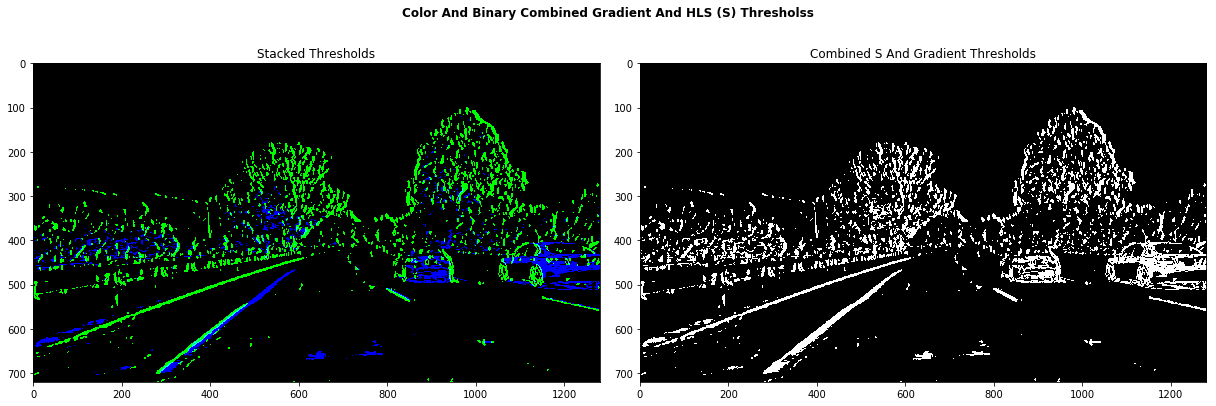

In [491]:
show_image_list(combined_binaries, combined_binaries_lbs, "Color And Binary Combined Gradient And HLS (S) Thresholss", cols=2, fig_size=(17, 6), show_ticks=True)

## Perspective Transform

We now need to define a trapezoidal region in the 2D image that will go through a perspective transform to convert into a bird's eye view.

In [894]:
copy_combined = np.copy(undist_test_imgs[1])
(bottom_px, right_px) = (copy_combined.shape[0] - 1, copy_combined.shape[1] - 1) 

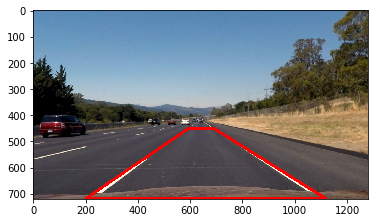

In [895]:
#pts = np.array([[250,bottom_px],[600,450],[700,450], [1180, bottom_px]], np.int32)
#pts = np.array([[200,bottom_px],[520,500],[770,500], [1120, bottom_px]], np.int32)
pts = np.array([[200,bottom_px],[595,450],[690,450], [1120, bottom_px]], np.int32)
cv2.polylines(copy_combined,[pts],True,(255,0,0), 10)
plt.imshow(copy_combined)

In [896]:
src_pts = pts.astype(np.float32)
dst_pts = np.array([[200, bottom_px], [200, 0], [1000, 0], [1000, bottom_px]], np.float32)

In [897]:
def perspective_transform(img, src, dst):    
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

In [898]:
test_img_persp_tr = perspective_transform(undistorted_test_img, src_pts, dst_pts)

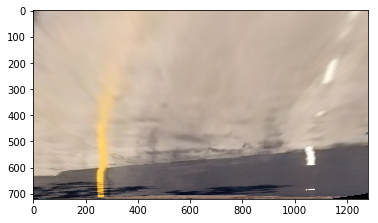

In [899]:
plt.imshow(test_img_persp_tr)

Here the lane is curved, and our perspective transform takes this into account too.

In [900]:
test_imgs_pers_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

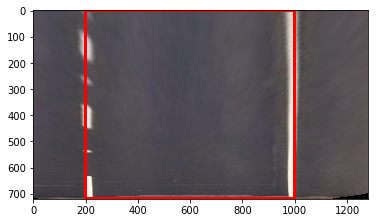

In [901]:
test_persp_img = np.copy(test_imgs_pers_tr[1])
dst = dst_pts.astype(np.int32)
cv2.polylines(test_persp_img,[dst],True,(255,0,0), 10)
plt.imshow(test_persp_img)

We can see that our perspective transform keeps straight lines straight, which is a required sanity check.

In [902]:
test_undist_imgs_and_p_tr = np.asarray(list(zip(undist_test_imgs, test_imgs_pers_tr)))
test_undist_imgs_and_p_tr_names = np.asarray(list(zip(undist_test_img_names, undist_test_img_names)))

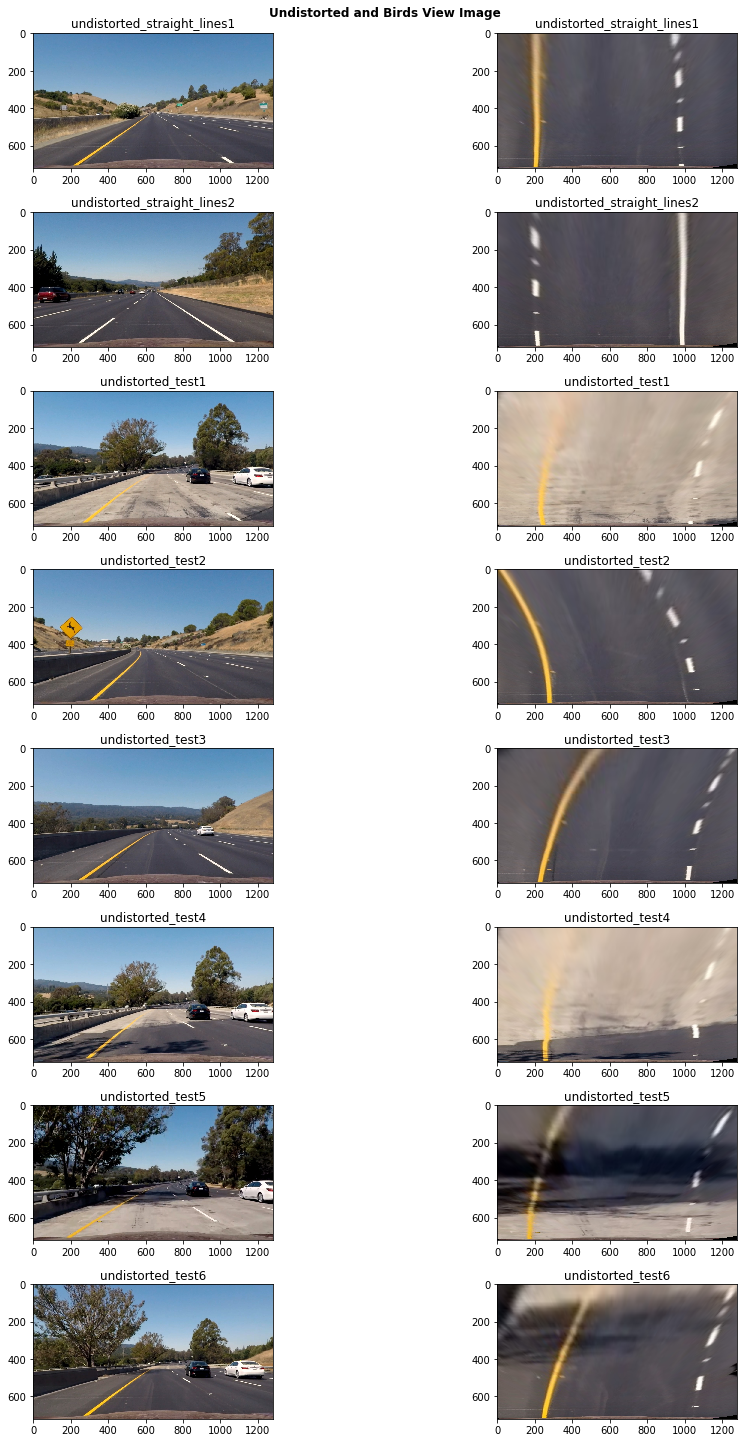

In [903]:
show_image_list(test_undist_imgs_and_p_tr, test_undist_imgs_and_p_tr_names, "Undistorted and Birds View Image", fig_size=(15, 20))

At this stage it is fitting to start definining a pipeline of operations to perform and visualise perspective transform on thresholding binary images.

In [906]:
def get_combined_binary_thresholded_img(undist_img):
    """
    """
    undist_img_gray = to_grayscale(undist_img)
    sx = abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120))
    sy = abs_sobel(undist_img_gray, x_dir=False, kernel_size=15, thres=(50, 150))
    sxy = mag_sobel(undist_img_gray, kernel_size=15, thres=(50, 150))
    sxy_combined_dir = combined_sobels(sx, sy, sxy, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))   
    
    undist_img_hls = to_hls(undist_img)
    hls_s_thresholds = threshold_img(undist_img_hls, 2, thres=(150, 255))
    
    combined_binary = np.zeros_like(hls_s_thresholds)
    combined_binary[(sxy_combined_dir == 1) | (hls_s_thresholds == 1)] = 1
    
    return combined_binary

In [907]:
test_imgs_combined_binary_thres = np.asarray(list(map(lambda img: get_combined_binary_thresholded_img(img), undist_test_imgs)))


In [908]:
test_imgs_combined_binary_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), test_imgs_combined_binary_thres))) 

In [909]:
test_imgs_combined_binary_and_psp_tr = np.asarray(list(zip(test_imgs_combined_binary_thres, test_imgs_combined_binary_psp_tr)))
test_imgs_combined_binary_and_psp_tr_names = np.asarray(list(zip(undist_test_img_names, undist_test_img_names)))

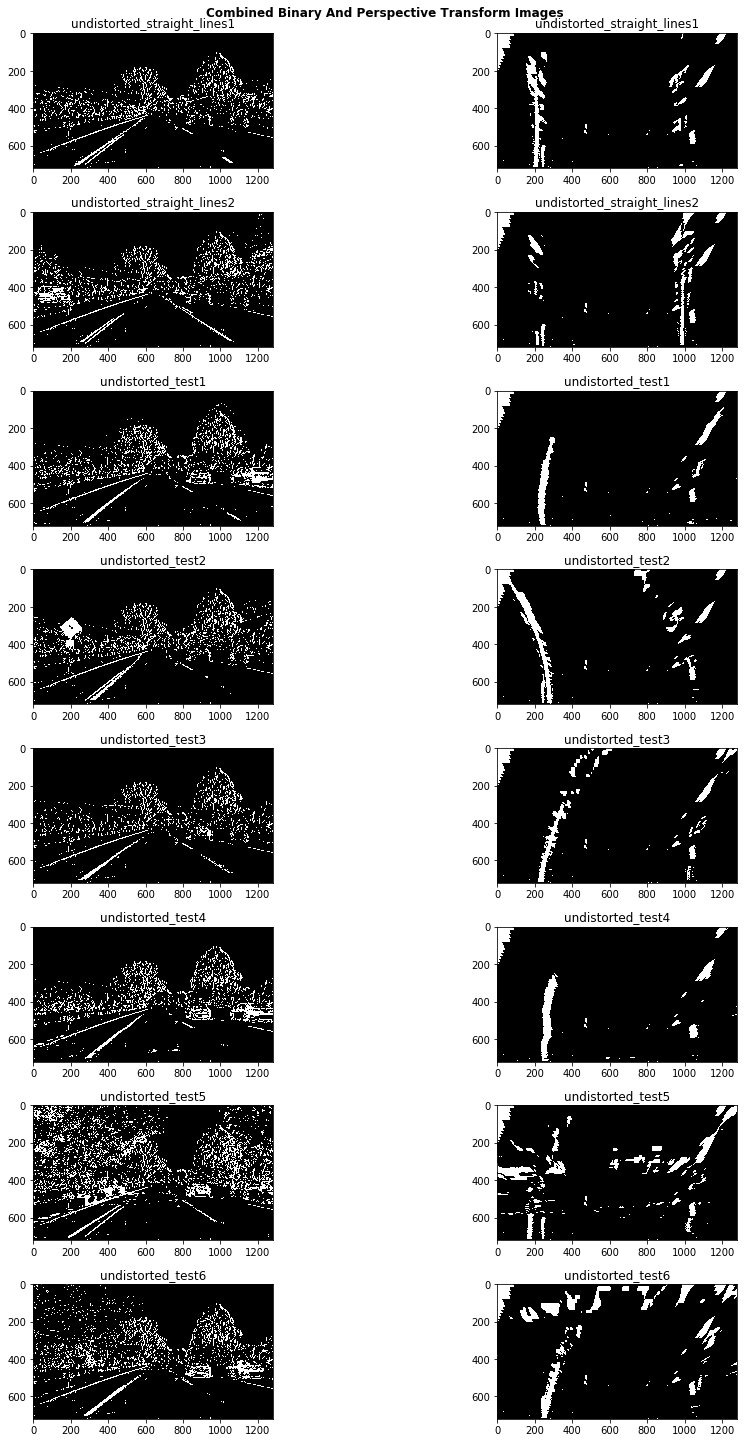

In [910]:
show_image_list(test_imgs_combined_binary_and_psp_tr, test_imgs_combined_binary_and_psp_tr_names, "Combined Binary And Perspective Transform Images", fig_size=(15, 20))

The perspective transform still works reasonably well but we are faced with lots of artefacts on the image.

In [944]:
sample_combined_binary_psp_tr = test_imgs_combined_binary_psp_tr[4]

In [975]:
sample_combined_binary_psp_tr[sample_combined_binary_psp_tr.shape[0]//2:,:].shape

(360, 1280)

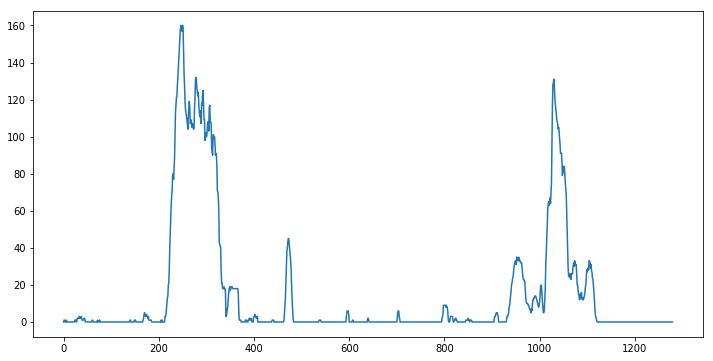

In [977]:
histogram = np.sum(sample_combined_binary_psp_tr[sample_combined_binary_psp_tr.shape[0]//2:,:], axis=0)
plt.figure(figsize=(12,6))
plt.plot(histogram)

In [974]:
histogram.shape

(1280,)

In [1018]:
def compute_and_visualize_sliding_windows(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image, summing pixel values column wise 
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Create an image for the contour
    window_img = np.zeros_like(out_img)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    # NOTE: nonzero returns a tuple of arrays in y and x directions
    nonzero = binary_warped.nonzero()
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        # We are moving our windows from the bottom to the top of the screen (highest to lowest y value)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        # Defining our window's coverage in the horizontal (i.e. x) direction 
        # Notice that the window's width is twice the margin
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image - we are passing in points of the one of the rectangle's diagonals
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 5) 
        
        # Identify the nonzero pixels in x and y within the window
#        print("Shape of good_left_ind={0}".format(((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
 #       (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]))
        
        # Super crytic and hard to understand...
        # Basically nonzerox and nonzeroy have the same size and any nonzero pixel is identified by
        # (nonzeroy[i],nonzerox[i]), therefore we just return the i indices within the window that are nonzero
        # and can then index into nonzeroy and nonzerox to find the ACTUAL pixel coordinates that are not zero
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices since we now have a list of multiple arrays (e.g. ([1,3,6],[8,5,2]))
    # We want to create a single array with elements from all those lists (e.g. [1,3,6,8,5,2])
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    
    ###### LANE CURVATUURE #### Define conversions in x and y from pixels space to meters
    y_eval = np.max(ploty)
    ym_per_pix = 20/720.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/800.0 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,200, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,200, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    
    # Now draw the lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    #return (left_fit, right_fit, out_img)

534.086556229 m 157.843050001 m


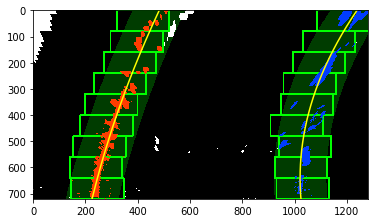

In [1019]:
compute_and_visualize_sliding_windows(sample_combined_binary_psp_tr)